# Perspective Transformation

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import numpy as np

In [2]:
dataset_root = r"E:\Dataset\nuscenes\nuscenes-mini"
nusc = NuScenes(version='v1.0-mini', dataroot=dataset_root, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.560 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
example_scene = nusc.scene[0]
first_sample_token = example_scene['first_sample_token']
sample = nusc.get('sample', first_sample_token)
sample['data']

{'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
 'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
 'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
 'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
 'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
 'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
 'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
 'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
 'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
 'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
 'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
 'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'}

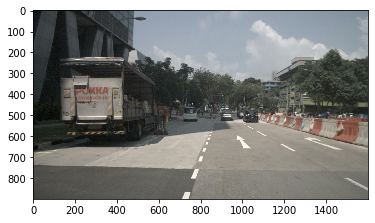

In [4]:
cam_front_data = nusc.get('sample_data', sample['data']['CAM_FRONT'])
lidar_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
radar_front_data = nusc.get('sample_data', sample['data']['RADAR_FRONT'])
image_path = os.path.join(dataset_root, cam_front_data['filename'])
src_image = cv2.imread(image_path)
src_rgb_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB);
plt.figure()
plt.imshow(src_rgb_image)
plt.show()

Intrinsic Camera Parameters characterize the geometry of the image plane inside the camera.
![projection](./images/projection.svg)
f denotes focal length. k_u and k_v are pixel densities in x, y directions.
![intrinsic matrix](./images/intrinsic_matrix.svg)

In [5]:
calibrated_front_camera = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])
calibrated_lidar_top = nusc.get('calibrated_sensor', lidar_data['calibrated_sensor_token'])
calibrated_radar_front = nusc.get('calibrated_sensor', radar_front_data['calibrated_sensor_token'])
calibrated_front_camera['camera_intrinsic']

[[1266.417203046554, 0.0, 816.2670197447984],
 [0.0, 1266.417203046554, 491.50706579294757],
 [0.0, 0.0, 1.0]]

Besides intrinsic matrix, the projection still needs extrinsic parameters, which denote the position of the world coordinate system relative to the camera coordinate system.
![extrinsic matrix](./images/extrinsic_matrix.svg)

In [6]:
calibrated_front_camera['translation']

[1.70079118954, 0.0159456324149, 1.51095763913]

In [7]:
calibrated_front_camera['rotation']

[0.4998015430569128,
 -0.5030316162024876,
 0.4997798114386805,
 -0.49737083824542755]

The rotation of camera is represented in form of quaternion. The conversion between quaternion and Euler angle is discribed in the following formular:
![title](https://wikimedia.org/api/rest_v1/media/math/render/svg/e03f373d475143a18284d28f70a6a65055463339)

* Yaw: around vertical axis
* Pitch: around lateral axis (head up/down)
* Roll: around longitudinal axis

The local coordinate system has the same direction of "radar_front".
![title](https://www.nuscenes.org/public/images/data.png)

In [8]:
q = Quaternion(array=calibrated_front_camera['rotation'])
yaw =  q.yaw_pitch_roll[0]
pitch =  q.yaw_pitch_roll[1]
roll =  q.yaw_pitch_roll[2]
rotation_matrix = q.transformation_matrix
print(np.shape(rotation_matrix))
print("yaw:", yaw/np.pi*180, "pitch:", pitch/np.pi*180, "roll:", roll/np.pi*180)
rotation_matrix

(4, 4)
yaw: 44.756520709595215 pitch: 89.54131122701148 roll: -134.80356664964012


array([[ 5.68477868e-03, -5.63666773e-03,  9.99967955e-01,
         0.00000000e+00],
       [-9.99983517e-01, -8.37115272e-04,  5.68014846e-03,
         0.00000000e+00],
       [ 8.05071338e-04, -9.99983763e-01, -5.64133364e-03,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

The transformation from the global coordinate to the camera plane can be described by the following equation: 
![homogeneous_transformation](./images/homogeneous_transformation.svg)

However, the inversive operation is impossible, because P_1 is non-invertible. Intuitively, we lose the information of one dimension from 2D image to build a 3D world. All objects on the same sight line will be overlapped by the forefront one. We have two ways to solve this problem:
* We use three manually selected points in the image to estimate the resultant transformation matrix.
* Manually define that the z-axis component is constant (e.g. 0). We need to rebuild the projection transformation matrix.

At the beginning, we try the first approach:

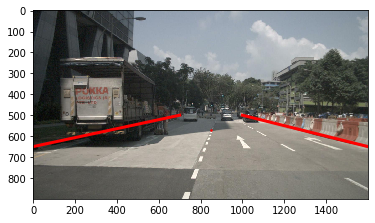

In [9]:
w = src_rgb_image.shape[1]
h = src_rgb_image.shape[0]
plt.figure()
plt.plot([700,0],[500,650], c="r", linewidth=3.0)
plt.plot([1000,w],[500,650], c="r", linewidth=3.0)
plt.scatter([850],[570],c='r',s=2)
plt.imshow(src_rgb_image)
plt.show()

[-1.73020117e+02 -4.52128228e+02 -2.26554186e-01]
[[-3.240e-01 -1.777e+00  1.116e+03]
 [-0.000e+00 -6.457e+00  3.230e+03]
 [-0.000e+00 -2.151e-03  1.000e+00]]


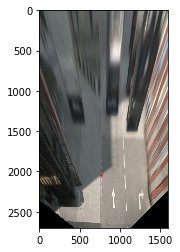

In [10]:
# example image point
imgPoint = np.array([850, 570,1])

# topleft, bottomleft, topright, bottomright
target_h = h*3
src = np.array([[700, 500], 
                [0, 650], 
                [1000, 500], 
                [w, 650]], dtype = "float32")
dst = np.array([[0, 0],
                [100, target_h*0.9], 
                [w*0.8, 0], 
                [1400, target_h*0.9]], dtype = "float32")
M = cv2.getPerspectiveTransform(src, dst)
print(np.matmul(M, imgPoint))

print(M.astype(np.float16))
warped_img = cv2.warpPerspective(src_rgb_image, M, 
                                 (w, target_h),
                                 cv2.INTER_CUBIC)
plt.figure()
plt.scatter([760],[2050],c='r',s=2)
plt.imshow(warped_img) # Show results
plt.show()

The second approach is much more complicated. Since we cannot inverse the projection matrix, we need to assume that the projection plane is located on the ground. The steps are:
* Get the height of camera, angle to the horizontal line
* Calculate the perspective transformation matrix MP
* Project pixels from image plane to ground plane
* Interpolate the empty part
* Reproject the ground to bird's eye view

The projection follows a one-point perspective transformation.
![title](images/perspetive_transformation.svg)

In [11]:
H = calibrated_front_camera['translation'][2]  # ignore car's height
normal_vector = np.array([0,0,1,1])
camera_vector = np.dot(rotation_matrix, normal_vector.T)[:3]
angle = np.pi/2 - np.arccos(np.dot(camera_vector, np.array([0,0,-1]))/np.linalg.norm(camera_vector))
print("Height:", h, "Camera vecor:", camera_vector, "Alpha:", np.rad2deg(angle))

A_int = np.array(calibrated_front_camera['camera_intrinsic'])
f = A_int[0,0]
print("MA intrinsic matrix\n", A_int, "Focus distance:", f)

Height: 900 Camera vecor: [ 0.99996796  0.00568015 -0.00564133] Alpha: 0.3232263229509278
MA intrinsic matrix
 [[1.26641720e+03 0.00000000e+00 8.16267020e+02]
 [0.00000000e+00 1.26641720e+03 4.91507066e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] Focus distance: 1266.417203046554


From the intrinsic parameters, we can find that the camera is almost horizontally installed. To avoid any infinite value, we should limit the projection region in the lower half of the image.

Assumed that a projection point on the ground plane is P:
![title](images/3D_point.svg)
The mapping between the image and ground plane can be described by the following equations:
![title](images/equations.svg)
The transformation is nonlinear.

In [12]:
alpha_min = np.pi/2 - np.arctan(h/2/f)
d_min = np.tan(alpha_min)*H
print("alpha_min:", np.rad2deg(alpha_min), "d_min:", d_min)

alpha_min: 70.4381882701889 d_min: 4.252228327264087


To approximate the perspective transformation (4x4), which has 8 unknown parameters, we need to find 4 point pairs between the image and ground plane.

In [13]:
P_image = np.array([[0,h,1],[w,h,1],[w*0.25,h*0.75,1],[w*0.75,h*0.75,1]], dtype = "float32")
A_int_inv = np.linalg.inv(A_int)
P_image_map = np.dot(A_int_inv, P_image.T).T[:,:2]
print(P_image_map)

[[-0.64454827  0.32255795]
 [ 0.61885844  0.32255795]
 [-0.32869659  0.14489138]
 [ 0.30300677  0.14489138]]


In [31]:
scale_z = 0.04   # mm -> m
scale_x = 50   # mm -> m
offset_x = 10
P_bird = np.ones(P_image_map.shape)
P_bird[:,1] = P_bird[:,1]/P_image_map[:,1]*H*f*scale_z
P_bird[:,0] = (P_bird[:,0]/P_image_map[:,1]*H*P_image_map[:,0]+offset_x)*scale_x
print(P_bird)

[[349.03718207 237.29103681]
 [644.9458772  237.29103681]
 [328.61415451 528.25855288]
 [657.99090041 528.25855288]]


[[-1.0000000e+00  1.2246468e-16  1.0000000e+03]
 [-1.2246468e-16 -1.0000000e+00  4.0000000e+03]
 [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]


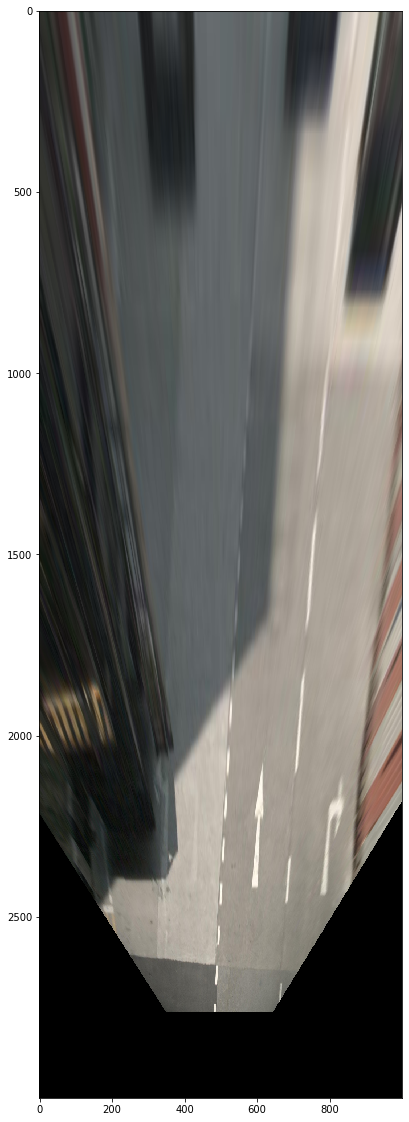

In [32]:
M_persp = cv2.getPerspectiveTransform(P_image[:,:2].astype(np.float32), P_bird.astype(np.float32))
dst_size = np.array([1000, 3000])
dst_center = dst_size/2
print(rot_mat)
warped_img2 = cv2.warpPerspective(src_rgb_image, M_persp, tuple(dst_size), cv2.INTER_CUBIC)[:3000,:,:]
warped_img2 = cv2.flip(warped_img2, 0)
plt.figure(figsize=[10,20])
plt.imshow(warped_img2) # Show results
plt.savefig('images/perspective_result.png')
plt.show()